In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2024-02-06 12:00:59--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-02-06 12:00:59 (33.2 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/d228747/releases/pybind11-inst

<div class="alert alert-warning">
<font size="5"><strong>Foundamentals: solving the Poisson equation</strong></font>
</div>
The aim of this first computer laboration is to get started with using Fenics software for solving partial differential equations (PDEs) using finite element methods. We next describe the Finite Element Method through a simple model.

<div class="alert alert-info">
<font size="2"><strong>FEniCS is a collection of open-source finite element software for solving partial differential equations in any space dimensions and polynomial degrees. The software is written in a way that the high-level user does not need to get access to its low level sub-projects, for instance the assembly loops, quadrature points, linear algebra back-ends. Python and C++ are used as the user interface, where the problem formulations, meshing, boundary
conditions and post-processings can be performed. Below we discuss the implementation for the Poisson's equation using the Python interface.</strong></font>
</div>

We solve the Poisson equation with Dirichlet boundary conditions.

\begin{align}
-\Delta u & =f, & \mbox{ in }\Omega\\
u & =u_{D}, & \mbox{ on }\partial\Omega
\end{align}

Here, $u$ is the unknown function, $f$ is a prescribed function, $\Delta$ is the Laplace operator (sometimes written as $\nabla \cdot \nabla = \nabla^2$), $\Omega$ is the spatial domain, and $\partial \Omega$ is the boundary of $\Omega$.

The Poisson problem above is an example of a boundary-value problem. In three-dimensional space, we can write out the Poisson equation as
\begin{equation}
-\frac{\partial^2 u}{\partial x^2}-\frac{\partial^2 u}{\partial y^2}-\frac{\partial^2 u}{\partial z^2} = f(x,y,z).
\end{equation}
The unknown $u$ is now a function of three variables, $u=u(x,y,z)$, defined over a three-dimensional domain $\Omega$. When $\displaystyle f=0$, we obtain **Laplace's equation**.

The study of the solutions of Laplace’s equation and the related Poisson equation is called **potential theory**. The Poisson equation describes various physical phenomena including but not limited to the following:

1. **steady heat transfer** with a heat source, where $u$ is the temperature;

2. **electrostatics**, where $u$ is the electrostatic potential;

3. **steady incompressible irrotational flow**, where $u$ is the velocity potential.


<div class="alert alert-warning">
<font size="5"><strong>Variational formulation (Weak formulation)</strong></font>
</div>

To obtain the weak formulation, we multiply the PDE by an arbitrary function
$v \in V_0 = \left\{ u \in H^1(\Omega)  | u = 0 \text{ on } \partial \Omega \right\}$ (called **test function**) and integrate over the domain $\Omega$ leading to

$$ - \int_{\Omega} \Delta u  v  dx = \int_{\Omega} f v  dx, \quad \forall v \in V_0. $$

By applying the Gauss theorem or partial integration to the left side and set $v = 0$ on the Dirichlet boundary, we get

\begin{equation*}
-\int_{\Omega} (\Delta u) v \text{d}x
= \int_{\Omega} \nabla u\cdot\nabla v\text{d}x -
\underbrace{\int_{\partial\Omega} \frac{\partial u}{\partial n} v\text{d}s}_{\color{red}{=0}} = \int_\Omega f v dx
\end{equation*}

The quantity $\frac{\partial u}{\partial n} = \nabla v . n$ is the derivative of $v$ in the normal direction $n$, and is called the normal derivative of $v$.
We find that:

\begin{equation}
\label{2}\tag{2}
\int_{\Omega}\nabla u \cdot \nabla v \text{d}x = \int_{\Omega} f v \text{d}x.
\end{equation}


The weak formulation of the problem (1) reads:

$$ \boxed{\mbox{ Find } u \in V_{u_D} \mbox{ such that }  a(u, v) = L(v) \quad \forall  v \in V_0} \label{3}\tag{3}$$

where the bilinear and linear forms $a(u, v)$ and $L(v)$ are given by

\begin{equation}
a(u, v) = \int_{\Omega} \nabla u \cdot \nabla v \text{d}x, \qquad  L(v) = \int_{\Omega} f(x) v \text{d}x \\ V_{u_D} = \left\{ u \in H^1(\Omega) | u = u_D \text{ on } \partial \Omega \right\}.
\end{equation}

<div class="alert alert-warning">
<font size="5"><strong>Standard Finite Element Approximation</strong></font>
</div>

To obtain the finite element discretization we then introduce a triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and we define a finite dimensional subspace $V_h \subset V_0$ consisting of globally continuous functions that are piecewise polynomial on each element of $\mathcal{T}_h$ and vanish on the boundary:

 $$V_{h} = \{ v_h \in V_h| v_h = 0 \text{ on } \partial \Omega\}.$$

The standard finite element approximation of (3) then reads:

Find $u_h \in \hat V_h = \{ v_h \in V_h | v_h = u_D \text{ on } \partial \Omega\}$ such that:
$$ \int_{\Omega} \nabla u_h \cdot \nabla v_h  dx = \int_{\Omega} f_h v_h dx, \quad \forall v_h \in V_{h}. \label{4}\tag{4}$$

$ \hat V_h$ is the space of trial functions, and $ V_h$ is the space of test functions. Specifying $V_h$ and $\hat{V}_h$ consists in choosing the mesh and the type of interpolation functions.


We then define

- the bilinear form $a(u_h, v_h) = \int_\Omega \nabla u_h \cdot \nabla v_h dx $;

- the linear form $L(v_h) = \int_\Omega f v_h dx $.

To construct an approximation method, we assume that $V_h$ is a finite n-dimensional vector space ($\mbox{dim}(V_h) = n$) of test functions. In this case, the space $V_h$ is characterised by a basis ($\phi_1, \phi_2,...,\phi_n$) so that a function $u_h \in V_h$ can be represented by a vector

$$ u_h = \sum_{i=1}^n {\rm u}_i \phi_i(x), $$

where ${\rm u}_i$ represents `degree of freedom` of $u_h$.

The variational problem (4) can be expressed in matrix form and this leads to a system of linear equations for the coefficients ${u}_i$:

$$ A U = B, \tag{5}$$
where

- $U = [u_1 .... u_n]^T$ is the vector collecting the coefficient of the finite element expansion of $u_h$,

- the entries of the matrix A are such that $A_{ij} = a(\phi_j, \phi_i)$,

- the entries of the right hand side B are such that $B_i = L(\phi_i)$.


So finding the solution of the variational problem amounts to solving a linear system  (5).

## Solving a PDE in FEniCS

### Concrete example:

Next, we need to specify $\{ {u_D},f,\Omega \}$. We choose a simple 2D domain: the unit square $\Omega = [0,1] \times [0,1]$ .

In order to compare the finite element solution to the exact solution, here we construct a model problem with the exact solution:

\begin{equation} u_{ex}(x,y) = 1 + {x^2} + 2{y^2}. \end{equation}

If we substitute this exact solution ${u_{ex}}$ into Poisson problem we find that $f$ is:

\begin{equation} f(x,y) = - 6 \end{equation}

and the boundary condition:

\begin{equation}{u_D}(x,y) = u_{ex}(x,y) = 1 + {x^2} + 2{y^2}. \end{equation}

We will demonstrate how to use **FEniCS** to convert a partial differential equation (PDE) written as a symbolic description into finite element code.

# Solving a boundary-value problem in FEniCS consists of the following steps:

## 1. Imports

We import the following Python packages:

- We start by importing `fenics` Python packages.
- `matplotlib` is a plotting library and the command `%matplotlib inline` is used to plot the result in the Notebook.
- `math` is the python built-in library of mathematical functions.

In [ ]:
# Import FEniCS
from fenics import *
#
import math

# Enable plotting inside the notebook
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline

## 2. Generating a mesh

The triangulation (mesh) of the unit square  $\Omega = [0,1]×[0,1]$ is automatically generated  by `UnitSquareMesh(8,8)`. The parameter 8 tells us that each side of the square is divided into 8 equal intervals.

The following statements generate and plots the mesh.

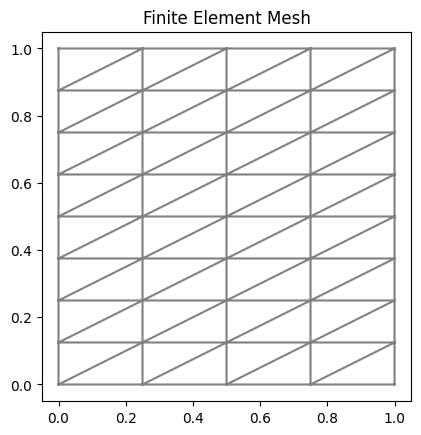

In [ ]:
# Create mesh
mesh = UnitSquareMesh(4, 8)
plot(mesh, title="Finite Element Mesh")
#plot(mesh)

<div class="alert alert-info">
To learn more about mesh generation tools, watch the following notebook: </div>

- [MESH GENERATION IN FENICS](Working-with-meshes.ipynb)

## 3. Define the finite element space

On the constructed mesh we define the space $𝑉_ℎ$ of continuous piecewise polynomial functions using the command `FunctionSpace`:

```
V = FunctionSpace(mesh, "P", d)
```

where `P` is the type of the desired finite element and some commonly used finite elements:

* "CG" = "Lagrange"  for Continuous Galerkin,

* "DG" creates a function space for discontinuous Galerkin methods,

* and also more specialized spaces such as Nedelec or Raviart

The last parameter `d` specifies the degree of the functions  on the element. `FeniCS` supports a wide variety of finite element spaces in 1D,2D and 3D, including non-conforming and vector-valued spaces.

In [ ]:
V = FunctionSpace(mesh, 'P', 1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00550151 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.317362 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

## Specifying trial and test functions

In the Galerkin methods, the trial and test functions belong to the same function space.

In [ ]:
u = TrialFunction(V)
v = TestFunction(V)

## 4. Define the coefficients of the PDE

 We first define the coefficients of the PDE using the `Constant` and `Expression` classes.

- `Constant` is used to define coefficients that do not depend on the space coordinates,

- `Expression` is used to define coefficients that are a known function of the space coordinates `x[0]` (x-axis direction) and `x[1]` (y-axis direction). In 3D, the $z$ coordinate will be denoted as `x[2]`.

For our specific model problem, we need to specify the boundary condition $u_D = 1+x^2+2y^2$ and the load $f = -6.0$.

In [ ]:
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
# Define the load
f = Constant(-6.0)   # Or f = Expression(’-6’, degree=0)

We set the degree to 2 so that u_D may represent the exact quadratic solution to our test problem.

Another way to define the load $f$ is:

```f = Expression('-6', degree=0)```

<div class="alert alert-info">
The Expression class is very flexible and can be used to create complex user-defined expressions. Check out the following notebook to learn more about:
    </div>

- [Expression class](newexp.ipynb)

## 5. Defining the variational problem

We need to specify the variational problem

$$ \int_{\Omega} \nabla u_h \cdot \nabla v_h dx = \int_{\Omega} f_h v_h dx, \quad \forall v_h \in V_{h}. \tag{4}$$

In FEniCS, the variational form is specified by translating the mathematical expressions of the integrands into a **Unified Form Language (UFL)**, which is a domain-specific language based on Python and C++ syntax.

Here, the bilinear form $a$ and the linear form $L$ are defined as:

The mathematical expressions | **FEniCS: Unified Form Language   (UFL)**       
------------------------------|:---------------------------------:
$\nabla u_h$ |$grad(u_h)$
$a(u_h, v_h) = \int_{\Omega}\nabla u_h\cdot \nabla v_h dx$|$inner( grad(u_h), grad(v_h)  )*dx$
$L(v_h) = \int_{\Omega}fv_h dx$|$f*v_h*dx$

In [ ]:
# Define variational problem
# Left-hand side
a = inner(grad(u), grad(v))*dx # or dot(grad(u), grad(v))*dx
# Right-hand side
L = f*v*dx

Here, `a` is the integrand on the left-hand side, `L` is the integrand on the right-hand side, `dx` denotes the integration measure connected to the domain.

## Defining boundary conditions

The Dirichlet boundary condition
$$ u = u_D \quad {\rm on} \; \partial\Omega$$
is imposed using the **DirichletBC** class.

To construct this object we need to provide

- the finite element space `Vh`

- the value `u_D` of the solution at the Dirichlet boundary.

- the object `Boundary` that defines on which part of $\partial \Omega$ we want to impose such condition.


For a Dirichlet boundary condition, a simple domain can be defined
by

```
"on_boundary" # The entire boundary
```

In [ ]:
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

## Forming and solving the linear system

We are now ready to solve the PDE using the solve function.

In [ ]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

We can also explicitly form the linear system and solve it instead.
```
A, b = assemble_system(a, L, bc)
solve(A, u.vector(), b)
```
This may be useful if we need to modify the matrix and vector, or export them to files.

In [ ]:
u(0.1,0.7)


2.0125

## Post processing
We can then plot the solution and the mesh together for inspection:

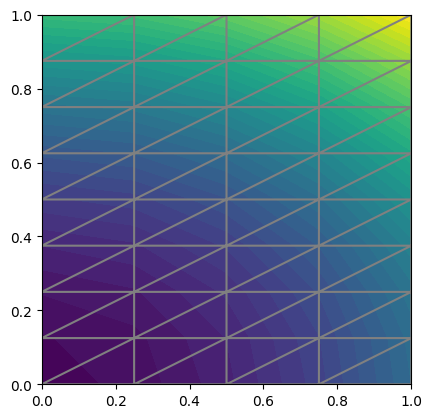

In [ ]:
# Plot solution and mesh
plot(u)
plot(mesh)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_da3dbd3713237c9dc86a1c4ac309ca5b94ed72fd

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_28]'
  Unique elements:           'CG1(?,?), CG3(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG3(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0261047 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_780eb9ddb42feb9c6996c1225460f0d8c3f18bb9

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00381088 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0213087 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

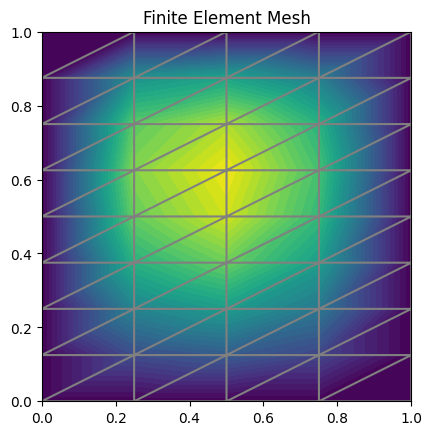

In [ ]:
from re import X
# Import FEniCS
from fenics import *
#
import math

# Enable plotting inside the notebook
import matplotlib.pyplot as plt

# to plot the result in the Notebook
%matplotlib inline
#
# Create mesh
mesh = UnitSquareMesh(4, 8)
plot(mesh, title="Finite Element Mesh")
#
V = FunctionSpace(mesh, 'P', 1)
#
u = TrialFunction(V)
v = TestFunction(V)
#
# Define boundary condition
u_D = Constant(10.0)
# Define the load
f = Expression('cos(x[0])*sin(x[1])', degree=3)
#
# Define variational problem
# Left-hand side
a = inner(grad(u), grad(v))*dx # or dot(grad(u), grad(v))*dx
# Right-hand side
L = f*v*dx
#
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

#
# Compute solution
u = Function(V)
solve(a == L, u, bc)

#
# Plot solution and mesh
plot(u)
plot(mesh)

We can  save the plot to a **PNG** file, the following statements will write the plot to **myfile.png**.

In [ ]:
filename = 'myfile.png'
plt.savefig ( filename )

<Figure size 640x480 with 0 Axes>

We can also save the result into a VTK file for more advanced visualization and post-processing using **ParaView**.

In [ ]:
# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

In FEniCS, it is easy to perform some error analysis.



## 6. Compute the discretization error

For this problem, the exact solution is known.
We can therefore compute the following norms of the discretization error (i.e. the of the difference between the finite element solution $u_h$ and the exact solution $u_{\rm ex}$)
$$ \| u_{\rm ex} - u_h \|_{L^2{(\Omega})} := \sqrt{ \int_{\Omega} (u_{\rm ex} - u_h)^2 \, dx }. $$

In [ ]:
# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_76fc3cd9625812038c7471125b47cc4c7ae9ad4e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00482893 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 1.48642 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6ce8a510087f4e034b86fc6d0bf27a775643b273

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'DG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG4(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0221674 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00352859 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0149021 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00466013 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0145144 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8f9acf292fa7994d298cc8c76ab5884f206fd987

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00644135 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.016866 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00479865 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0145845 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


In [ ]:
# Computation of grad(u)
v=grad(u)[0]   # x-component of grad(u)
plot(v, interactive=True)

# Exercice 1 : Poisson's Equation on Unit Disk

Modify the previous script to solve this problem numerically on a unit disk:
\begin{align}
-\Delta u & = 1, & \mbox{ in }\Omega\\
u & = 0, & \mbox{ on }\partial\Omega
\end{align}

The exact solution is:
$$u_e(x,y) = \frac{1-x^2-y^2}{4}$$

**Note:**
To define a unit disk and its discretization : The following code uses **mshr** to create a mesh.
```
.
from mshr import *
.
.
center = Point ( 0.0, 0.0 )
r = 1.0
resolution = 20
mesh = generate_mesh ( Circle ( center, r ), resolution )
plot ( mesh, title = "CircleMesh" )
```

 number of cells =  392
Plotting a Circle Mesh
error_L2  = 0.14994696370644106
error_max = 0.16806523521284378


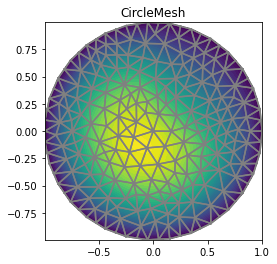

In [ ]:
from fenics import *
from mshr import *
#
#  Circle.
#
center = Point ( 0.0, 0.0 )
r = 1.0
resolution = 10
mesh = generate_mesh ( Circle ( center, r ), resolution )
print (" number of cells = ",mesh.num_cells())
print ( "Plotting a Circle Mesh" )
plot ( mesh, title = "CircleMesh" )
#
V = FunctionSpace(mesh, 'P', 1)
#
u = TrialFunction(V)
v = TestFunction(V)
#
# Define boundary condition
u_0 = Constant(0.0)
# Define the load
#f = Constant(1.0)
f = Expression('x[0]>=0 && x[1]>=0 ? pow(x[0], 2) : 2', degree=2)
#
# Define variational problem
# Left-hand side
a = dot(grad(u), grad(v))*dx
# Right-hand side
L = f*v*dx
#
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_0, boundary)
#
# Compute solution
u = Function(V)
solve(a == L, u, bc)
#
# Plot solution and mesh
plot(u)
plot(mesh)
#
# Compute error in L2 norm
# Define Exact Solution
u_D = Expression('(1 - x[0]*x[0] - x[1]*x[1])/4', degree=2)
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

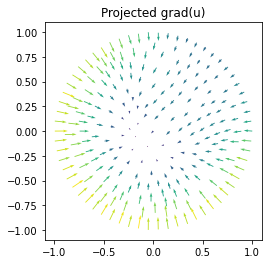

In [ ]:
plot(grad(u), title="Projected grad(u)")

In [ ]:
DOLFIN_EPS

NameError: ignored

# Exercice 2 : Poisson's Equation multiple Dirichlet conditions

Modify the previous script to solve this problem numerically on a unit square:
\begin{align}
-\Delta u & = 0, & \mbox{ in } & \Omega\\
u & = 1 + y, & \mbox{ on } & \Gamma_{right}\\
u & = x, & \mbox{ on } & \Gamma_{bottom}\\
u & = y, & \mbox{ on } & \Gamma_{left}\\
u & = x + y, & \mbox{ on } & \Gamma_{top}
\end{align}

**Note:**
To partion the boundary and define the Dirichlet boundary condition:

```
def left_boundary(x, on_boundary):
    return on_boundary and abs(x[0]) < DOLFIN_EPS

u_L = Expression('x[1]', degree=3)
bc_L = DirichletBC(V, u_L, left_boundary)
    
def right_boundary(x, on_boundary):
    return on_boundary and abs(x[0] - 1) < DOLFIN_EPS

u_R = Expression('1 + x[1]', degree=3)
bc_R = DirichletBC(V, u_R, right_boundary)
  
def top_boundary(x, on_boundary):
    return abs(x[1] -1 ) < DOLFIN_EPS

u_T = Expression('x[0] + x[1]', degree=3)
bc_T = DirichletBC(V, u_T, top_boundary)
      
def bottom_boundary(x, on_boundary):
    return abs(x[1]) < DOLFIN_EPS

u_B = Expression('x[0]', degree=3)
bc_B = DirichletBC(V, u_B, bottom_boundary)

# A list of boundary Dirichlet conditions for solve

bcs = [bc_L, bc_R, bc_T, bc_B]
```

# Solution to Exercise 2

/home/lotfi/anaconda3/lib/python3.7/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


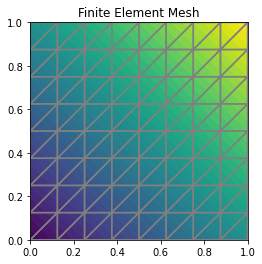

In [ ]:
from dolfin import *

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
plot( mesh, title = "UnitIntervalMesh" )
plot(mesh, title="Finite Element Mesh")
#
V = FunctionSpace(mesh, "Lagrange", 1)

# Define boundary condition
def left_boundary(x, on_boundary):
    return on_boundary and abs(x[0]) < DOLFIN_EPS

u_L = Expression('x[1]', degree=3)
bc_L = DirichletBC(V, u_L, left_boundary)

def right_boundary(x, on_boundary):
    return on_boundary and abs(x[0] - 1) < DOLFIN_EPS

u_R = Expression('1 + x[1]', degree=3)
bc_R = DirichletBC(V, u_R, right_boundary)

def top_boundary(x, on_boundary):
    return abs(x[1] -1 ) < DOLFIN_EPS

u_T = Expression('x[0] + x[1]', degree=3)
bc_T = DirichletBC(V, u_T, top_boundary)

def bottom_boundary(x, on_boundary):
    return abs(x[1]) < DOLFIN_EPS

u_B = Expression('x[0]', degree=3)
bc_B = DirichletBC(V, u_B, bottom_boundary)

# collect the 4 boundary conditions in a list

bcs = [bc_L, bc_R, bc_T, bc_B]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("0.0", degree=0)
a = inner(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bcs)

# Save solution in VTK format
file = File("ex2.pvd")
file << u

# Plot solution
plot(u, interactive=True)

# Exercice 3 : Poisson's Equation with Imported Mesh


Modify the previous script to solve this problem numerically in a mesh imported from **xml** format:

\begin{align}
-\Delta u & = 0, & \mbox{ in } & \Omega\\
u & = 1 + y + x, & \mbox{ on } & \partial \Omega
\end{align}

**Note:** To import a mesh from **xml** format:
```
mesh = Mesh("file_name.xml")
```

# Solution to Exercise 3

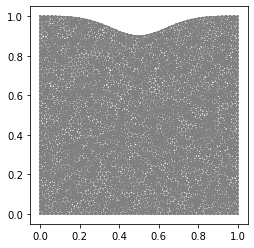

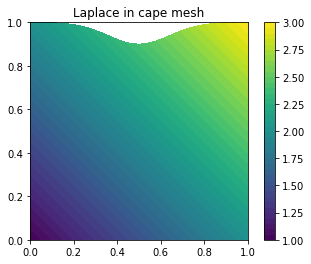

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt

# Import mesh and define function space
mesh = Mesh("cape.xml")
plot(mesh)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define boundary condition
u_0 = Expression("x[0] + x[1] + 1", degree=3)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_0, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("0.0", degree=0)
a = inner(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution in VTK format
file = File("laplace_cape.pvd")
file << u

# Plot solution
plt.figure()
c = plot(u, title='Laplace in cape mesh')
plt.colorbar(c)
plt.show()
